In [1]:
import pyspark

print(pyspark.__version__)

3.4.1


In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import matplotlib
# 设置全局中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或 ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示异常

spark = SparkSession.builder.appName("DataAnalysis")\
    .config("spark.default.parallelism", 4) \
    .config("spark.driver.memory", "16g")\
    .config("spark.executor.memory", "16g")\
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate() 
    
base_path = "10Gdata/part-"
file_path = [f"{base_path}{str(i).zfill(5)}.parquet" for i in range(7)]
df = spark.read.parquet(*file_path)

df.printSchema()
df.show(5, truncate=False)

root
 |-- id: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- chinese_name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- age: long (nullable = true)
 |-- income: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- country: string (nullable = true)
 |-- chinese_address: string (nullable = true)
 |-- purchase_history: string (nullable = true)
 |-- is_active: boolean (nullable = true)
 |-- registration_date: string (nullable = true)
 |-- credit_score: long (nullable = true)
 |-- phone_number: string (nullable = true)

+---+-------------------------+----------+------------+--------------------+---+--------+------+-------+--------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----------------+------------+------------+
|id |ti

# ​年龄分布直方图

<Axes: xlabel='age_group', ylabel='count'>

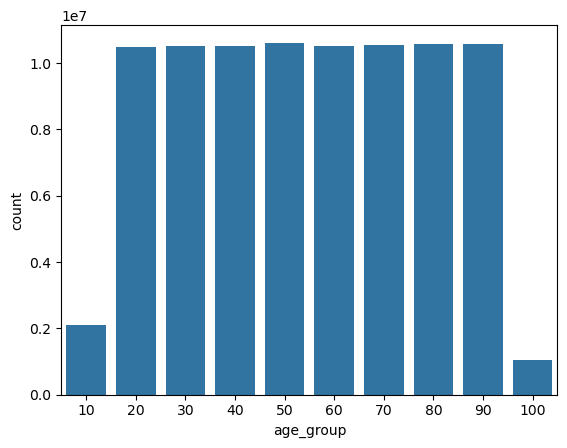

In [11]:
import seaborn as sns
import pyspark.sql.functions as F
age_dist = df.groupBy(
    (F.floor(F.col('age')/10)*10).alias('age_group')
).count().orderBy('age_group').toPandas()
sns.barplot(x='age_group', y='count', data=age_dist)

In [13]:
print("filter error age: now count:" + str(df.count()))
df = df.filter((F.col('age') >= 0) & (F.col('age') <= 120))
print("after filter count: " + str(df.count()))

filter error age: now count:87500000
after filter count: 87500000


# 性别-国家交叉热力图

<Axes: ylabel='gender'>

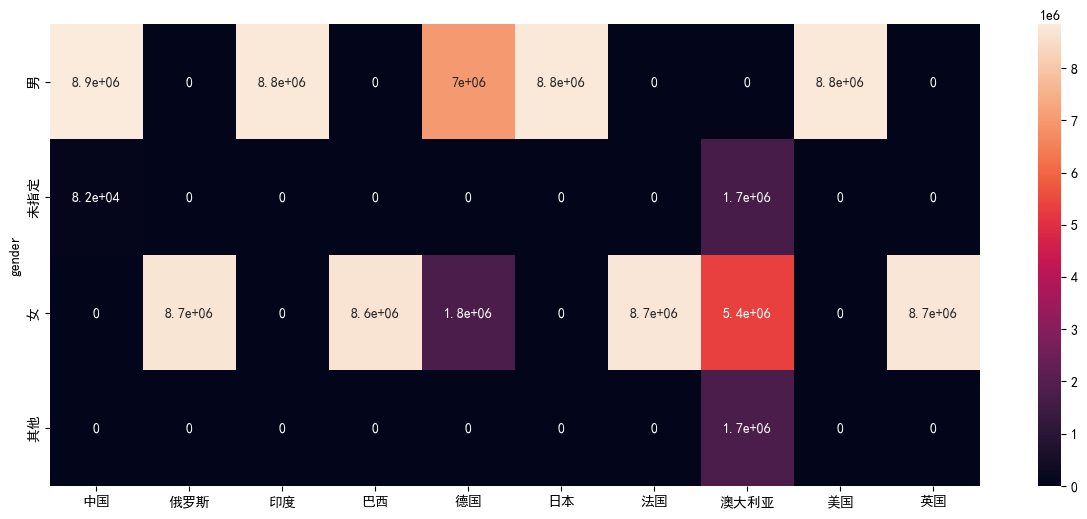

In [18]:
import matplotlib.pyplot as plt
import matplotlib
# 设置全局中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或 ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示异常

cross_tab = df.groupBy('gender').pivot('country').count().fillna(0)
plt.figure(figsize=(15,6))
sns.heatmap(cross_tab.toPandas().set_index('gender'), annot=True)

In [4]:
import pyspark.sql.functions as F
# 检查缺失值
missing_values = {}
for col_name in df.columns:
    missing_count = df.filter(F.col(col_name).isNull()).count()
    missing_ratio = missing_count / df.count()
    missing_values[col_name] = (missing_count, missing_ratio)
print("缺失值统计：")
for col_name, (count, ratio) in missing_values.items():
    print(f"{col_name}: 数量={count}, 比例={ratio:.2%}")

缺失值统计：
id: 数量=0, 比例=0.00%
timestamp: 数量=0, 比例=0.00%
user_name: 数量=0, 比例=0.00%
chinese_name: 数量=0, 比例=0.00%
email: 数量=0, 比例=0.00%
age: 数量=0, 比例=0.00%
income: 数量=0, 比例=0.00%
gender: 数量=0, 比例=0.00%
country: 数量=0, 比例=0.00%
chinese_address: 数量=0, 比例=0.00%
purchase_history: 数量=0, 比例=0.00%
is_active: 数量=0, 比例=0.00%
registration_date: 数量=0, 比例=0.00%
credit_score: 数量=0, 比例=0.00%
phone_number: 数量=0, 比例=0.00%


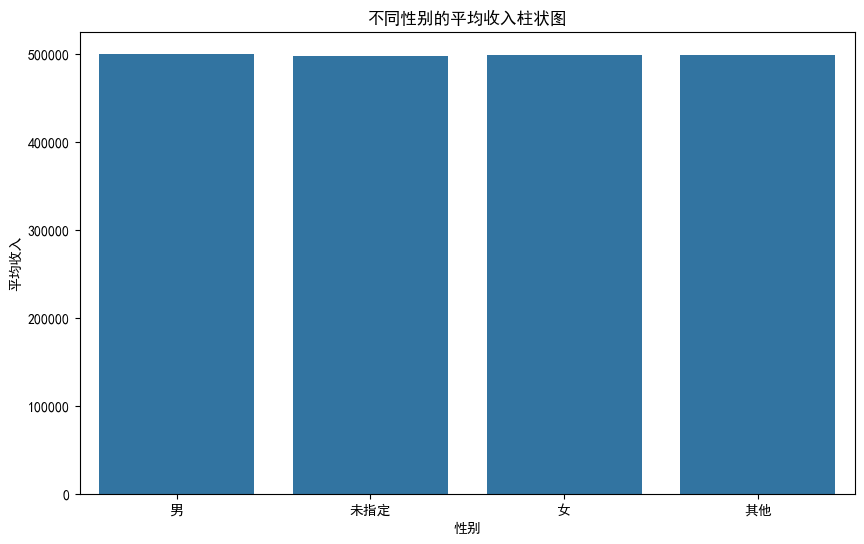

In [6]:
import seaborn as sns
# 2. 不同性别的平均收入柱状图
gender_income = df.groupBy("gender").avg("income").toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x="gender", y="avg(income)", data=gender_income)
plt.title("不同性别的平均收入柱状图")
plt.xlabel("性别")
plt.ylabel("平均收入")
plt.show()

In [10]:
from pyspark.sql.functions import col, from_json, explode, when
from pyspark.sql.types import StructType, StructField, FloatType, StringType, ArrayType, IntegerType

# 定义 JSON 结构
schema = StructType([
    StructField("average_price", FloatType(), True),
    StructField("category", StringType(), True),
    StructField("items", ArrayType(StructType([
        StructField("id", IntegerType(), True)
    ])), True)
])

# 将 purchase_history 列从字符串解析为 JSON 格式
df = df.withColumn("purchase_history", from_json(col("purchase_history"), schema))

# 年龄分层
df = df.withColumn("age_group",
                   when(col("age") < 30, "青年")
                   .when((col("age") >= 30) & (col("age") < 60), "中年")
                   .when(col("age") >= 60, "老年")
                   )

# 收入分层
df = df.withColumn("income_group",
                   when(col("income") < 100000, "低收入")
                   .when((col("income") >= 100000) & (col("income") < 500000), "中等收入")
                   .when(col("income") >= 500000, "高收入")
                   )

# 购买类别
df = df.withColumn("purchase_category", col("purchase_history.category"))

# 提取用户画像
user_profile = df.select("user_name", "age_group", "income_group", "gender", "country", "purchase_category")
user_profile.show()

+----------+---------+------------+------+-------+-----------------+
| user_name|age_group|income_group|gender|country|purchase_category|
+----------+---------+------------+------+-------+-----------------+
|   UZPFPZJ|     中年|      低收入|    女| 俄罗斯|             家居|
|     UEHSG|     中年|    中等收入|    女|   巴西|             食品|
|  fxuujvnk|     老年|      高收入|    男|   美国|             书籍|
|    DDERCI|     老年|    中等收入|    男|   德国|             书籍|
|RTABMQKQLG|     中年|    中等收入|    男|   中国|             家居|
|   ypngbve|     老年|      高收入|    男|   中国|             食品|
| KBFYEUSBU|     老年|      低收入|    女|   法国|         电子产品|
|   kjmkgzk|     老年|      高收入|    女|   英国|             食品|
|     KYORF|     老年|    中等收入|    女|   英国|             家居|
|     EOCGW|     青年|    中等收入|    男|   美国|             家居|
|   ihmeebf|     老年|      高收入|    女|   法国|             家居|
|  uqvhllji|     老年|      高收入|    男|   中国|         电子产品|
|    GGRRCT|     老年|    中等收入|    女|   巴西|             服装|
|   qjyqfap|     老年|      高收入|    女| 

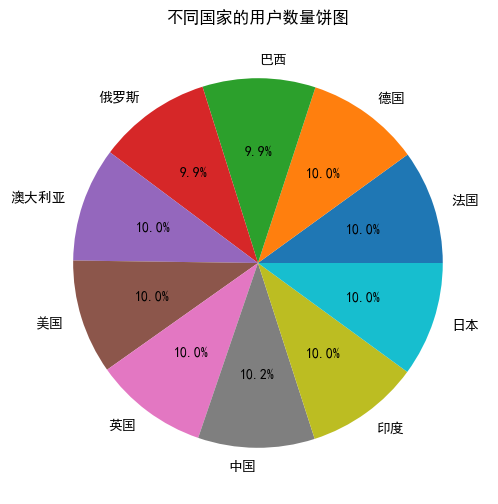

In [7]:
# 3. 不同国家的用户数量饼图
country_count = df.groupBy("country").count().toPandas()
plt.figure(figsize=(10, 6))
plt.pie(country_count["count"], labels=country_count["country"], autopct='%1.1f%%')
plt.title("不同国家的用户数量饼图")
plt.show()

In [ ]:
purchase_hist = df.select('purchase_history')
purchase_hist.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|purchase_history                                                                                                                                                             |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{"average_price":15.940000000000001,"category":"家居","items":[{"id":631},{"id":762},{"id":233},{"id":535},{"id":118},{"id":449},{"id":256},{"id":404},{"id":99},{"id":638}]}|
|{"average_price":563.4100000000001,"category":"食品","items":[{"id":425},{"id":678},{"id":72},{"id":666}]}                                                                   |
|{"average_price":669.34,"category":"书籍","items":[{"id":395},{"id":148},{"id":731},{"id":847}]}                             

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
# 将 purchase_history 列从字符串解析为 JSON 格式
from pyspark.sql.functions import from_json
from pyspark.sql.types import StructType, StructField, FloatType, StringType, ArrayType, IntegerType


# 定义 JSON 结构
schema = StructType([
    StructField("average_price", FloatType(), True),
    StructField("category", StringType(), True),
    StructField("items", ArrayType(StructType([
        StructField("id", IntegerType(), True)
    ])), True)
])

df_hist = df.select('id', 'purchase_history')
df_hist = df_hist.withColumn("purchase_history", from_json(F.col("purchase_history"), schema))

exploded_df = df_hist.select(F.col("id"), F.col("purchase_history.average_price"), F.col("purchase_history.category"), F.explode(F.col("purchase_history.items")).alias("item"))

# 提取 item 中的 id
final_df = exploded_df.select(F.col("id"), F.col("average_price"), F.col("category"), F.col("item.id").alias("item_id"))

final_df.show()

+---+-------------+--------+-------+
| id|average_price|category|item_id|
+---+-------------+--------+-------+
|  1|        15.94|    家居|    631|
|  1|        15.94|    家居|    762|
|  1|        15.94|    家居|    233|
|  1|        15.94|    家居|    535|
|  1|        15.94|    家居|    118|
|  1|        15.94|    家居|    449|
|  1|        15.94|    家居|    256|
|  1|        15.94|    家居|    404|
|  1|        15.94|    家居|     99|
|  1|        15.94|    家居|    638|
|  2|       563.41|    食品|    425|
|  2|       563.41|    食品|    678|
|  2|       563.41|    食品|     72|
|  2|       563.41|    食品|    666|
|  3|       669.34|    书籍|    395|
|  3|       669.34|    书籍|    148|
|  3|       669.34|    书籍|    731|
|  3|       669.34|    书籍|    847|
|  4|       637.66|    书籍|    908|
|  4|       637.66|    书籍|    793|
+---+-------------+--------+-------+
only showing top 20 rows



In [14]:
from pyspark.sql.functions import avg, count

# 计算每个类别的平均价格
category_avg_price = final_df.groupBy("category") \
    .agg(avg("average_price").alias("avg_price"))

category_avg_price.show()

# 计算每个类别下的商品数量
category_item_count = final_df.groupBy("category") \
    .agg(count("item_id").alias("item_count"))

category_item_count.show()

+--------+------------------+
|category|         avg_price|
+--------+------------------+
|    家居| 503.3654090694123|
|    书籍|504.99776866725006|
|    服装|506.70137173238703|
|    食品|504.98769962640637|
|电子产品| 505.6885003862283|
+--------+------------------+

+--------+----------+
|category|item_count|
+--------+----------+
|    家居|  95908750|
|    书籍|  96165750|
|    服装|  96509875|
|    食品|  96109000|
|电子产品|  96086750|
+--------+----------+



In [16]:
spark.catalog.clearCache()

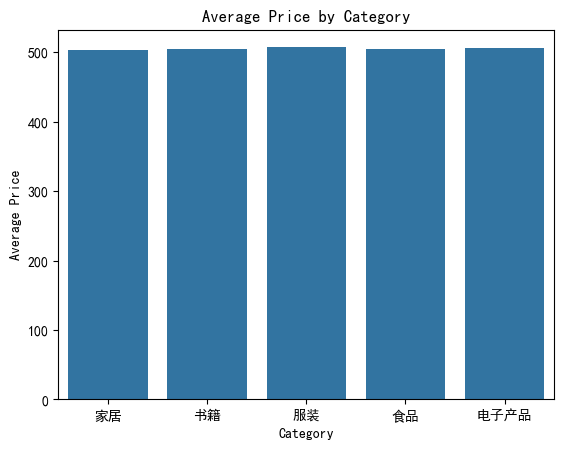

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 将结果转换为 Pandas DataFrame
category_avg_price_pd = category_avg_price.toPandas()

# 绘制柱状图
sns.barplot(x="category", y="avg_price", data=category_avg_price_pd)
plt.xlabel("Category")
plt.ylabel("Average Price")
plt.title("Average Price by Category")
plt.show()